In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import pickle
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
sns.set()

In [2]:
raw_df = pd.read_csv('loan_data_2007_2014.csv',index_col=0)
raw_df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
raw_df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

#### For LD model we need data only for members who actually defaulted

In [4]:
default_df = raw_df[raw_df['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])].copy()

#### Train Test Split

In [5]:
# train test split
raw_train, raw_test = train_test_split(default_df, test_size=0.20, random_state=42)

### Cleaning Train dataset

In [6]:
missing_per = raw_train.isna().sum()/raw_train.shape[0]*100
missing_per

id                               0.000000
member_id                        0.000000
loan_amnt                        0.000000
funded_amnt                      0.000000
funded_amnt_inv                  0.000000
term                             0.000000
int_rate                         0.000000
installment                      0.000000
grade                            0.000000
sub_grade                        0.000000
emp_title                        7.557534
emp_length                       5.368914
home_ownership                   0.000000
annual_inc                       0.000000
verification_status              0.000000
issue_d                          0.000000
loan_status                      0.000000
pymnt_plan                       0.000000
url                              0.000000
desc                            63.403493
purpose                          0.000000
title                            0.005782
zip_code                         0.000000
addr_state                       0

In [7]:
# dropping variables with more than 10% missing values
drop_missing_col = missing_per.index[missing_per > 10]
clean_train = raw_train.drop(drop_missing_col,axis='columns')

In [8]:
# cleanning term variable
clean_train['term'] = clean_train['term'].str.split().str[0]
clean_train['term'] = clean_train['term'].astype(int)

In [9]:
# cleanning emp length

# filling nan and < 1 year to 0 years in employment length
clean_train['emp_length'].replace({np.nan :'0 year','< 1 year':'0 year'},inplace=True)

# extracting employment years from str using regex
clean_train['emp_length'] = clean_train['emp_length'].apply(lambda x : re.findall(r'\d+', x)[0])

# converting emp_length from str to int
clean_train['emp_length'] = clean_train['emp_length'].astype(int)

In [10]:
# converting earliest_cr_line to pandas datetime format
clean_train['earliest_cr_line'] = pd.to_datetime(clean_train['earliest_cr_line'],format='%b-%y')
clean_train['earliest_cr_line'].describe()

count                   34586
unique                    570
top       2000-10-01 00:00:00
freq                      276
first     1969-01-01 00:00:00
last      2068-10-01 00:00:00
Name: earliest_cr_line, dtype: object

In [11]:
# we see that last year is 2068 which is impossible as current dataset is dated 2014.
# subtracting 100 from the year where year value is greater than 2015
clean_train['earliest_cr_line'] = clean_train['earliest_cr_line'].apply(lambda x: x - pd.DateOffset(years=100) if x.year > 2014 else x)
clean_train['earliest_cr_line'].describe()

count                   34586
unique                    570
top       2000-10-01 00:00:00
freq                      276
first     1955-04-01 00:00:00
last      2011-09-01 00:00:00
Name: earliest_cr_line, dtype: object

In [12]:
# converting issue_d to pandas datetime format
clean_train['issue_d'] = pd.to_datetime(clean_train['issue_d'],format='%b-%y')
clean_train['issue_d'].describe()

count                   34588
unique                     91
top       2014-07-01 00:00:00
freq                     1403
first     2007-06-01 00:00:00
last      2014-12-01 00:00:00
Name: issue_d, dtype: object

In [13]:
clean_train['earliest_cr_line'].isna().sum()

2

In [14]:
# filling missing earlies cr line with issue date
clean_train['earliest_cr_line'] = np.where(clean_train['earliest_cr_line'].isna(),clean_train['issue_d'],clean_train['earliest_cr_line'])

In [15]:
# creating new feature : Credit History lenght at the time of loan issue
clean_train['credit_hist'] = clean_train['issue_d'] - clean_train['earliest_cr_line']
# converting credit hist to months
clean_train['credit_hist'] = clean_train['credit_hist'].dt.days//30
clean_train['credit_hist'] = clean_train['credit_hist'].astype(int)
clean_train['credit_hist'].describe()

count    34588.000000
mean       179.552099
std         86.001388
min          0.000000
25%        123.000000
50%        164.000000
75%        220.000000
max        709.000000
Name: credit_hist, dtype: float64

In [16]:
# remove unncessary columns
drop_not_req_col = ['sub_grade','emp_title','issue_d','loan_status','pymnt_plan',
                    'url','title','zip_code','addr_state','earliest_cr_line','last_credit_pull_d',
                    'loan_amnt','funded_amnt_inv','pub_rec','revol_bal','revol_util','total_acc',
                    'out_prncp_inv','total_pymnt_inv','collection_recovery_fee','last_pymnt_amnt',
                    'collections_12_mths_ex_med','policy_code','acc_now_delinq','last_pymnt_d','application_type','out_prncp']
clean_train.drop(drop_not_req_col,axis='columns',inplace=True)

In [17]:
clean_train.isna().sum()

id                     0
member_id              0
funded_amnt            0
term                   0
int_rate               0
installment            0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
purpose                0
dti                    0
delinq_2yrs            2
inq_last_6mths         2
open_acc               2
initial_list_status    0
total_pymnt            0
total_rec_prncp        0
total_rec_int          0
total_rec_late_fee     0
recoveries             0
credit_hist            0
dtype: int64

In [18]:
clean_train = clean_train.fillna(0)

### Feature Engineering

In [19]:
# computing %principal outstanding, %principal paid,  % interest paid on principal, %installment on principal, %annual income
clean_train['per_pymnt'] = clean_train['total_pymnt']/clean_train['funded_amnt']
clean_train['per_rec_prncp'] = clean_train['total_rec_prncp']/clean_train['funded_amnt']
clean_train['per_rec_int'] = clean_train['total_rec_int']/clean_train['funded_amnt']
clean_train['per_installment'] = clean_train['installment']/clean_train['funded_amnt']
clean_train['per_annual_inc'] = clean_train['annual_inc']/clean_train['funded_amnt']

In [20]:
drop_var = ['funded_amnt','total_pymnt','total_rec_prncp','total_rec_int','installment','annual_inc']
clean_train.drop(drop_var,axis='columns',inplace=True)

In [21]:
clean_train.sample(3)

,id,member_id,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,initial_list_status,total_rec_late_fee,recoveries,credit_hist,per_pymnt,per_rec_prncp,per_rec_int,per_installment,per_annual_inc
12986,789502,993415,36,10.59,B,7,RENT,Source Verified,debt_consolidation,14.99,0.0,2.0,7.0,f,0.0,0.00,128,0.389926,0.298402,0.091525,0.032545,5.153846
162455,3383549,4306812,36,15.31,C,5,MORTGAGE,Source Verified,debt_consolidation,6.44,0.0,0.0,8.0,f,0.0,3525.11,259,0.518470,0.284059,0.133694,0.034817,5.942857
117007,6187600,7659732,36,12.35,B,6,RENT,Not Verified,credit_card,17.96,0.0,0.0,7.0,w,0.0,0.00,163,0.734404,0.566839,0.167565,0.033382,6.240000


### Descriptive stats

In [22]:
clean_train.drop(['id','member_id'],axis=1).describe()

,term,int_rate,emp_length,dti,delinq_2yrs,inq_last_6mths,open_acc,total_rec_late_fee,recoveries,credit_hist,per_pymnt,per_rec_prncp,per_rec_int,per_installment,per_annual_inc
count,34588.000000,34588.000000,34588.000000,34588.000000,34588.000000,34588.000000,34588.00000,34588.000000,34588.000000,34588.000000,34588.000000,34588.000000,34588.000000,34588.000000,34588.000000
mean,44.399445,15.972150,5.469267,18.150453,0.270209,1.061611,10.96785,2.586601,920.303055,179.552099,0.469769,0.263553,0.145321,0.031430,6.005957
std,11.447261,4.277284,3.748753,7.821516,0.777622,1.298350,4.89669,10.529893,1589.013000,86.001388,0.255640,0.200519,0.089781,0.004590,6.047197
min,36.000000,5.420000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019236,0.892857
25%,36.000000,13.050000,2.000000,12.410000,0.000000,0.000000,8.00000,0.000000,0.000000,123.000000,0.276338,0.110617,0.081347,0.027054,3.000000
50%,36.000000,15.650000,5.000000,18.170000,0.000000,1.000000,10.00000,0.000000,148.090000,164.000000,0.424402,0.209804,0.129966,0.033210,4.210526
75%,60.000000,18.850000,10.000000,23.782500,0.000000,2.000000,14.00000,0.000000,1313.030000,220.000000,0.628597,0.367411,0.191784,0.034965,6.666667
max,60.000000,26.060000,10.000000,39.980000,17.000000,32.000000,76.00000,358.680000,33520.270000,709.000000,1.581723,0.999562,0.657184,0.040323,216.864865


In [23]:
clean_train.drop(['id','member_id'],axis=1).describe(include=np.object)

,grade,home_ownership,verification_status,purpose,initial_list_status
count,34588,34588,34588,34588,34588
unique,7,5,3,14,2
top,C,RENT,Verified,debt_consolidation,f
freq,9618,16210,14829,20856,25683


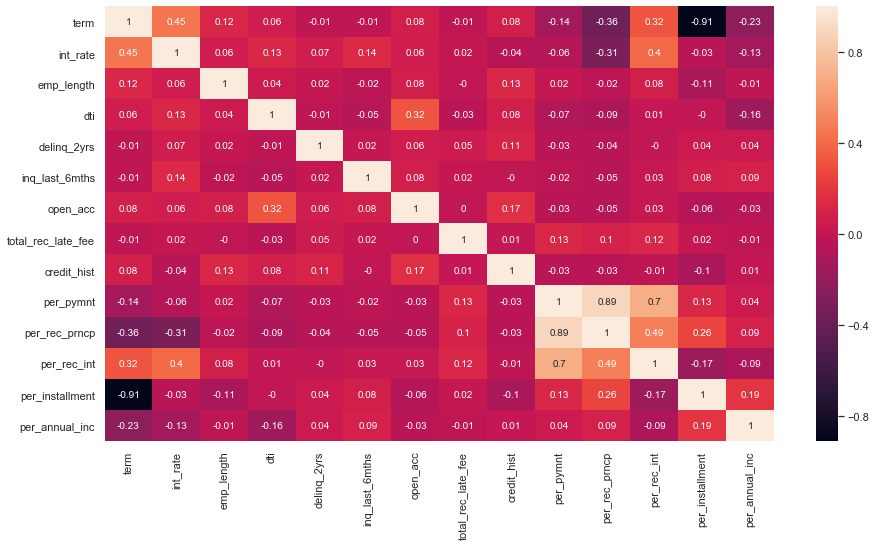

In [24]:
corr = clean_train.drop(['id','member_id','recoveries'],axis='columns').corr()
corr = corr.round(2)
plt.figure(figsize=(15,8))
sns.heatmap(corr,annot=True)

In [25]:
# removing highly corrleated variables
clean_train.drop(['per_rec_int'],axis=1,inplace=True)

### Independent Variables

In [26]:
numeric_col = clean_train.drop(['id','member_id','recoveries'],axis=1).describe().columns.tolist()
numeric_col

['term',
 'int_rate',
 'emp_length',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'total_rec_late_fee',
 'credit_hist',
 'per_pymnt',
 'per_rec_prncp',
 'per_installment',
 'per_annual_inc']

In [27]:
category_col = clean_train.drop(['id','member_id','recoveries'],axis=1).describe(include=np.object).columns.tolist()
category_col

['grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status']

In [28]:
# min max normalization
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(clean_train[numeric_col])
scaled_train = pd.DataFrame(scaled_train, columns=numeric_col)
scaled_train.sample(3)

,term,int_rate,emp_length,dti,delinq_2yrs,inq_last_6mths,open_acc,total_rec_late_fee,credit_hist,per_pymnt,per_rec_prncp,per_installment,per_annual_inc
7541,1.0,0.359981,1.0,0.547274,0.0,0.00000,0.105263,0.0,0.310296,0.114693,0.099456,0.163159,0.006893
4674,0.0,0.730136,0.3,0.306903,0.0,0.09375,0.157895,0.0,0.358251,0.436205,0.370564,0.862051,0.020464
12033,0.0,0.502907,0.6,0.172336,0.0,0.09375,0.171053,0.0,0.201693,0.553700,0.643023,0.750398,0.022393


In [29]:
# one hot encoding category variable
enc = OneHotEncoder(drop = 'first')
one_hot_vec = enc.fit_transform(clean_train[category_col])
one_hot_df = pd.DataFrame(one_hot_vec.toarray(),columns=enc.get_feature_names())
one_hot_df.sample(3)

,x0_B,x0_C,x0_D,x0_E,x0_F,x0_G,x1_NONE,x1_OTHER,x1_OWN,x1_RENT,x2_Source Verified,x2_Verified,x3_credit_card,x3_debt_consolidation,x3_educational,x3_home_improvement,x3_house,x3_major_purchase,x3_medical,x3_moving,x3_other,x3_renewable_energy,x3_small_business,x3_vacation,x3_wedding,x4_w
28770,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31112,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2187,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# converting columns name to more meaning full names
one_hot_df.columns = one_hot_df.columns.str.replace('x0_','grade_')
one_hot_df.columns = one_hot_df.columns.str.replace('x1_','home_ownership_')
one_hot_df.columns = one_hot_df.columns.str.replace('x2_','verification_status_')
one_hot_df.columns = one_hot_df.columns.str.replace('x3_','purpose_')
one_hot_df.columns = one_hot_df.columns.str.replace('x4_','initial_list_status_')
one_hot_df.columns = one_hot_df.columns.str.replace(' ','_')
one_hot_df.sample(3)

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source_Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
7647,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2106,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20197,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
final_train = pd.concat([scaled_train,one_hot_df],axis=1,sort=False)
final_train.isna().sum().sum()

0

In [32]:
final_train.sample(3)

,term,int_rate,emp_length,dti,delinq_2yrs,inq_last_6mths,open_acc,total_rec_late_fee,credit_hist,per_pymnt,per_rec_prncp,per_installment,per_annual_inc,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source_Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
21265,1.0,0.534399,0.5,0.566533,0.0,0.03125,0.092105,0.0,0.242595,0.396638,0.305103,0.252478,0.024265,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12287,0.0,0.431686,0.9,0.320660,0.0,0.09375,0.078947,0.0,0.172073,0.265170,0.211255,0.716223,0.033486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7629,1.0,0.657461,0.8,0.348924,0.0,0.03125,0.118421,0.0,0.145275,0.114778,0.074255,0.317701,0.006437,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Dependent Variables for LGD :  Recovery rate

In [33]:
recovery_rate = raw_train['recoveries']/raw_train['funded_amnt']
recovery_rate.sample(3)

47643     0.117062
200646    0.068421
29407     0.047013
dtype: float64

In [34]:
recovery_rate.describe()

count    34588.000000
mean         0.060646
std          0.089270
min          0.000000
25%          0.000000
50%          0.029466
75%          0.113656
max          1.220774
dtype: float64

In [35]:
# recovery rate should be between 0 and 1. 
# replace rate < 0  with 0
# replace rate > 1 with 1
recovery_rate = np.where(recovery_rate<0,0,recovery_rate)
recovery_rate = np.where(recovery_rate>1,1,recovery_rate)
final_train['recovery_rate'] = pd.Series(recovery_rate)
final_train['recovery_rate'].describe()

count    34588.000000
mean         0.060604
std          0.088796
min          0.000000
25%          0.000000
50%          0.029466
75%          0.113656
max          1.000000
Name: recovery_rate, dtype: float64

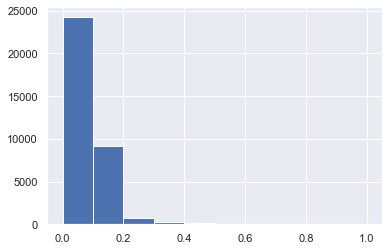

In [36]:
final_train['recovery_rate'].hist()

### Dependent Variables for EAD :  Credit Conversion Factor

In [37]:
ccf = (raw_train['funded_amnt']-raw_train['total_rec_prncp'])/raw_train['funded_amnt']
ccf.sample(3)

17184     0.837379
9946      0.252868
391370    0.881065
dtype: float64

In [38]:
ccf.describe()

count    34588.000000
mean         0.736447
std          0.200519
min          0.000438
25%          0.632589
50%          0.790196
75%          0.889383
max          1.000000
dtype: float64

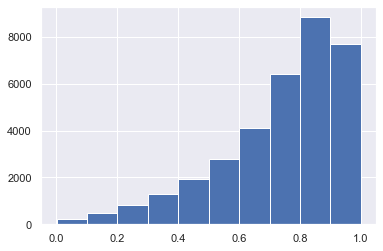

In [39]:
final_train['CCF'] = ccf.values
final_train['CCF'].hist()

In [40]:
final_train.insert(loc=0,column='member_id',value= raw_train['member_id'].values)
final_train.insert(loc=0,column='id',value= raw_train['id'].values)
final_train.sample(3)

,id,member_id,term,int_rate,emp_length,dti,delinq_2yrs,inq_last_6mths,open_acc,total_rec_late_fee,credit_hist,per_pymnt,per_rec_prncp,per_installment,per_annual_inc,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source_Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,recovery_rate,CCF
31702,6290665,7821907,0.0,0.431686,0.0,0.448474,0.0,0.00000,0.052632,0.0,0.321580,0.412174,0.474404,0.716213,0.019982,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525804
5781,3367296,4219906,0.0,0.229651,0.9,0.492496,0.0,0.00000,0.065789,0.0,0.253879,0.171286,0.209651,0.621553,0.015834,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.790441
23123,5616929,6999181,1.0,0.888566,0.2,0.671586,0.0,0.03125,0.302632,0.0,0.165021,0.416150,0.254116,0.445449,0.006219,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.745995


In [41]:
final_train.isna().sum().sum()

0

### Preparing Test Data

In [42]:
# Routine for processing Test DataFrame
def prepare_data(df,enc,scaler):
    clean_df = df.copy()
    
    # cleanning term variable
    clean_df['term'] = clean_df['term'].str.split().str[0]
    clean_df['term'] = clean_df['term'].astype(int)
    
    # filling nan and < 1 year to 0 years in employment length
    clean_df['emp_length'].replace({np.nan :'0 year','< 1 year':'0 year'},inplace=True)
    
    # extracting employment years from str using regex
    clean_df['emp_length'] = clean_df['emp_length'].apply(lambda x : re.findall(r'\d+', x)[0])

    # converting emp_length from str to int
    clean_df['emp_length'] = clean_df['emp_length'].astype(int)

    # converting earliest_cr_line to pandas datetime format
    clean_df['earliest_cr_line'] = pd.to_datetime(clean_df['earliest_cr_line'],format='%b-%y')
    
    
    # we see that last year is 2068 which is impossible as current dataset is dated 2014.
    # subtracting 100 from the year where year value is greater than 2015
    clean_df['earliest_cr_line'] = clean_df['earliest_cr_line'].apply(lambda x: x - pd.DateOffset(years=100) if x.year > 2014 else x)
    
    # converting issue_d to pandas datetime format
    clean_df['issue_d'] = pd.to_datetime(clean_df['issue_d'],format='%b-%y')
    
    
    # filling missing earlies cr line with issue date
    clean_df['earliest_cr_line'] = np.where(clean_df['earliest_cr_line'].isna(),clean_df['issue_d'],clean_df['earliest_cr_line'])
    
    # creating new feature : Credit History lenght at the time of loan issue
    clean_df['credit_hist'] = clean_df['issue_d'] - clean_df['earliest_cr_line']
    
    # converting credit hist to months
    clean_df['credit_hist'] = clean_df['credit_hist'].dt.days//30
    clean_df['credit_hist'] = clean_df['credit_hist'].astype(int)
    
    # computing %principal outstanding, %principal paid,  % interest paid on principal, 
    # %installment on principal, %annual income
    clean_df['per_pymnt'] = clean_df['total_pymnt']/clean_df['funded_amnt']
    clean_df['per_rec_prncp'] = clean_df['total_rec_prncp']/clean_df['funded_amnt']
    clean_df['per_installment'] = clean_df['installment']/clean_df['funded_amnt']
    clean_df['per_annual_inc'] = clean_df['annual_inc']/clean_df['funded_amnt']
    
    # final numeric features
    numeric_col = ['term', 'int_rate', 'emp_length', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
                   'total_rec_late_fee', 'credit_hist','per_pymnt', 'per_rec_prncp', 'per_installment','per_annual_inc']
    
    # final catgeory features
    category_col = ['grade', 'home_ownership','verification_status', 'purpose','initial_list_status']
    
    # final feature set
    clean_df = clean_df[numeric_col+category_col].copy()
    
    # fill na
    clean_df = clean_df.fillna(0)
    
    # min max scaling
    scaled_df = scaler.transform(clean_df[numeric_col])
    scaled_df = pd.DataFrame(scaled_df, columns=numeric_col)
    
    # one hot encoding
    one_hot_vec = enc.transform(clean_df[category_col])
    one_hot_df = pd.DataFrame(one_hot_vec.toarray(),columns=enc.get_feature_names())
    
    # converting columns name to more meaning full names
    one_hot_df.columns = one_hot_df.columns.str.replace('x0_','grade_')
    one_hot_df.columns = one_hot_df.columns.str.replace('x1_','home_ownership_')
    one_hot_df.columns = one_hot_df.columns.str.replace('x2_','verification_status_')
    one_hot_df.columns = one_hot_df.columns.str.replace('x3_','purpose_')
    one_hot_df.columns = one_hot_df.columns.str.replace('x4_','initial_list_status_')
    one_hot_df.columns = one_hot_df.columns.str.replace(' ','_')
    
    # final df
    final_df = pd.concat([scaled_df,one_hot_df],axis=1,sort=False)
    
    # Dependend variable for LGD : Recovery rate
    recovery_rate = df['recoveries']/df['funded_amnt']
    
    # recovery rate should be between 0 and 1. # replace rate < 0  with 0 ,# replace rate > 1 with 1
    recovery_rate = np.where(recovery_rate<0,0,recovery_rate)
    recovery_rate = np.where(recovery_rate>1,1,recovery_rate)
    final_df['recovery_rate'] = recovery_rate
    
    
    # Dependent Variables for EAD : Credit Conversion Factor
    ccf = (df['funded_amnt']-df['total_rec_prncp'])/df['funded_amnt']
    final_df['CCF'] = ccf.values
    
    # add id columns
    final_df.insert(loc=0,column='member_id',value= df['member_id'].values)
    final_df.insert(loc=0,column='id',value= df['id'].values)
    
    return final_df    

In [43]:
final_test = prepare_data(raw_test,enc,scaler)
final_test.sample(3)

,id,member_id,term,int_rate,emp_length,dti,delinq_2yrs,inq_last_6mths,open_acc,total_rec_late_fee,credit_hist,per_pymnt,per_rec_prncp,per_installment,per_annual_inc,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source_Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,recovery_rate,CCF
3993,1061135,1292930,0.0,0.304748,0.2,0.317409,0.0,0.0,0.131579,0.00000,0.078984,0.644375,0.807365,0.656357,0.017088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028375,0.192989
1993,6795363,8417483,0.0,0.296996,0.4,0.065533,0.0,0.0,0.131579,0.04182,0.198872,0.387565,0.401555,0.652735,0.080753,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084165,0.598621
2628,6547041,8099154,0.0,0.369671,1.0,0.311656,0.0,0.0,0.078947,0.00000,0.293371,0.375868,0.369734,0.686801,0.009242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088954,0.630428


In [44]:
final_test.isna().sum().sum()

0

In [45]:
final_train.shape,final_test.shape

((34588, 43), (8648, 43))

### Save the dataset

In [46]:
final_train.to_csv('LGD_EDA_Train_Clean.csv',index=False)
final_test.to_csv('LGD_EDA_Test_Clean.csv',index=False)

### Save Preprocessing object

In [47]:
# save one hot encoder and min max scaler for LGD_EAD Model
pickle.dump(enc,open("LGD_EDA_One_hot.pkl","wb"))
pickle.dump(scaler,open("LGD_EDA_Scaler.pkl","wb"))